# Data and Library Import

In [19]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import miceforest as mf
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import collections

In [5]:
train_df = pd.read_csv('cs-training.csv').drop(columns="Unnamed: 0")
test_df = pd.read_csv("cs-test.csv").drop(columns="Unnamed: 0")

In [6]:
train_df.shape, test_df.shape

((150000, 11), (101503, 11))

In [7]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Basic EDA to clean data

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Note that monthly income has missing entries. Monthly income is a good example of MNAR (missing not at random), that is, value of unobserved variable predicts missingness. However, it is unlikely that a loan application will have monthly income as an optional field to enter. Thus, I believe in this case, it can me MAR (missing at random). We will use the MICE (multiple imputation using chained equations) algorithm 

In [9]:
kds = mf.ImputationKernel(
    train_df
)
kds.mice(3)
train_df_imputed = kds.complete_data()

test_new = test_df.drop(columns = "SeriousDlqin2yrs")
kds_test = mf.ImputationKernel(
    test_new
)
kds_test.mice(3)
test_df_imputed = kds_test.complete_data()

(array([1.13218e+05, 2.90050e+04, 3.60800e+03, 2.09000e+02, 2.90000e+01,
        5.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

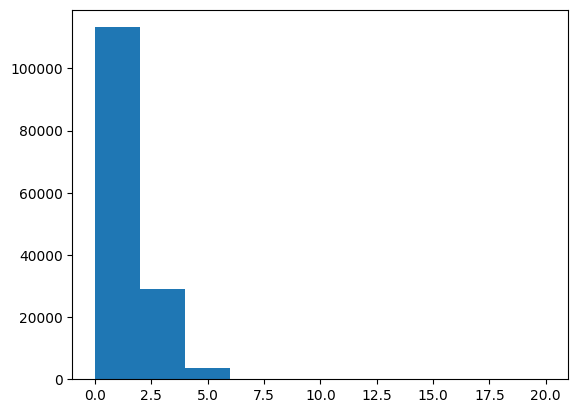

In [10]:
plt.hist(train_df["NumberOfDependents"])

(array([1.16945e+05, 2.91780e+04, 3.63100e+03, 2.10000e+02, 2.90000e+01,
        5.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

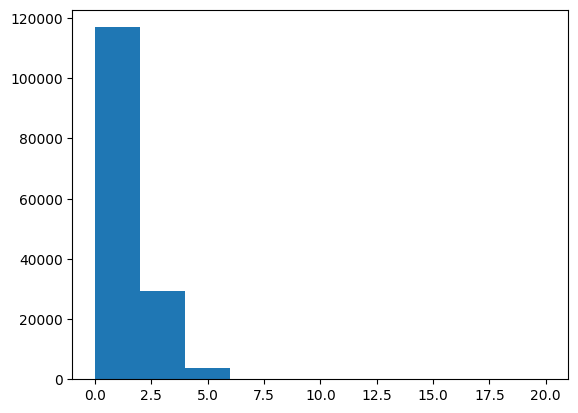

In [11]:
plt.hist(train_df_imputed["NumberOfDependents"])

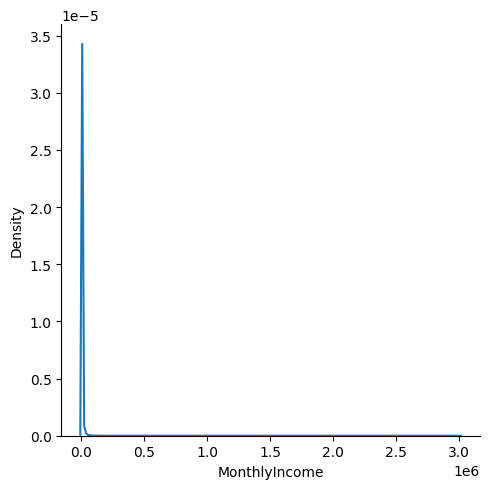

In [12]:
sns.displot(train_df, x = "MonthlyIncome", kind = "kde")

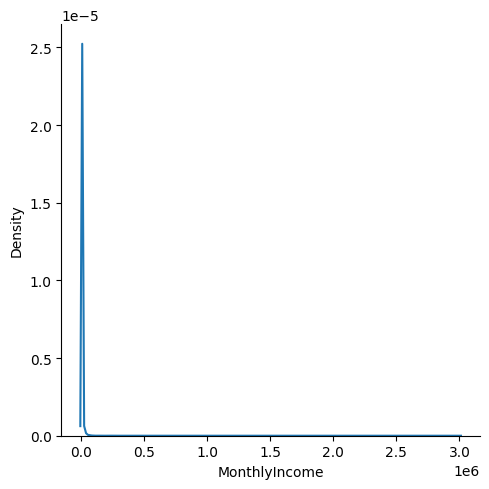

In [13]:
sns.displot(train_df_imputed, x = "MonthlyIncome", kind = "kde")

As seen above, there is no change in the distribution before and after imputation. This is good.

# Outlier removal

In [14]:
upper_arr = np.empty(0)
lower_arr = np.empty(0)
for i in train_df_imputed.columns:
    if i != "SeriousDlqin2yrs":
        upper = np.where(train_df_imputed[i] >= st.mean(train_df_imputed[i]) + (3 * st.stdev(train_df_imputed[i])))
        lower = np.where(train_df_imputed[i] <= st.mean(train_df_imputed[i]) - (3 * st.stdev(train_df_imputed[i])))
        upper_arr = np.append(upper_arr, upper)
        lower_arr = np.append(lower_arr, lower)

drop_idx = np.unique(np.append(upper_arr, lower_arr))

train_no_outlier = train_df_imputed.drop(index = drop_idx)

In [15]:
train_no_outlier.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,3815.0,8,0,3,0,0.0


In [16]:
train_df_imputed.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Part 1

## What are the factors that have high correlation with probaility of loan default?

age                                    -0.114053
MonthlyIncome                          -0.035174
NumberOfOpenCreditLinesAndLoans        -0.033204
NumberRealEstateLoansOrLines           -0.028680
DebtRatio                              -0.017798
RevolvingUtilizationOfUnsecuredLines    0.012133
NumberOfDependents                      0.047951
NumberOfTime60-89DaysPastDueNotWorse    0.271161
NumberOfTime30-59DaysPastDueNotWorse    0.274925
NumberOfTimes90DaysLate                 0.325369
SeriousDlqin2yrs                        1.000000
Name: SeriousDlqin2yrs, dtype: float64


<AxesSubplot:>

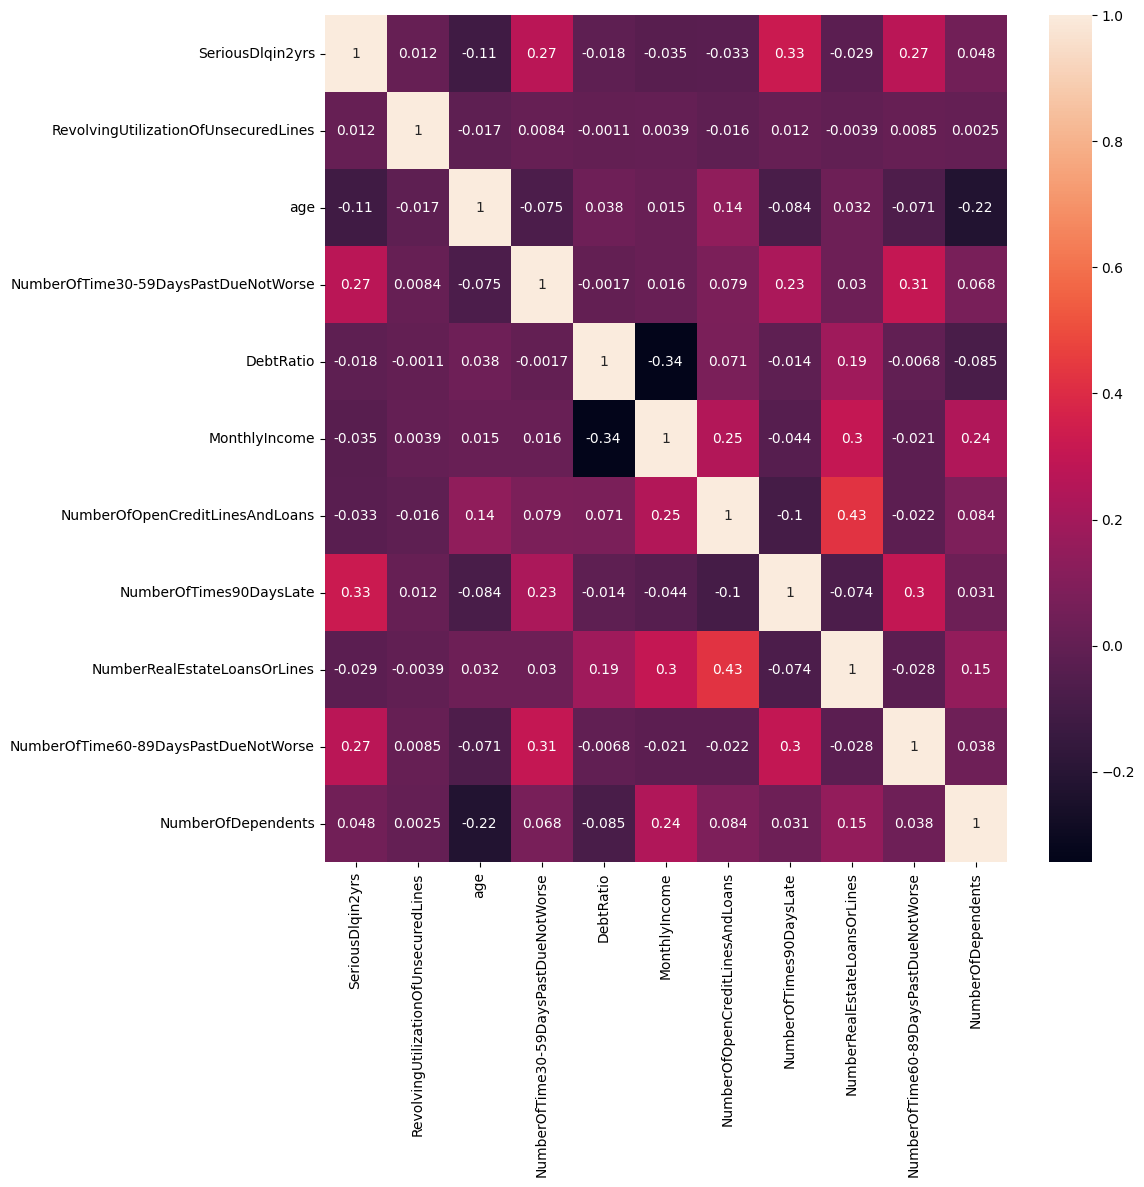

In [17]:
corr_mat = train_no_outlier.corr()
print(corr_mat["SeriousDlqin2yrs"])
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, yticklabels = corr_mat.columns, annot=True)

As seen from the heat map and matrix above, factors that have high correlation with the probability of default are:
1. Number of times 90 days late
2. NumberOfTime30-59DaysPastDueNotWorse
3. NumberOfTime60-89DaysPastDueNotWorse
4. MonthlyIncome
5. Number of dependents
6. Age

## Interaction effects?

As seen from the heat map above there are several factors that are correlated with each other. Note that interaction effect essentially means that the levels (or value) of one independent variable depends on the levels (or value) of another independent variable.

1. Age is negatively correlated with number of dependents. This makes sense as most people start families in their 20s to 30s, which means they will have dependents. As they get older, their children become adults, and thus the number of dependents will decrease.
2. NumberOfTime30-59DaysPastDueNotWorse is positively correlated with NumberOfTime60-89DaysPastDueNotWorse. This makes sense because if one is 30-59 days past due, they are more likely to past due 60-89 days
3. Monthly income is negatively correlated with debt ratio. This makes sense because if one has a higher income, they are less likley to buy things using debt. 
4. NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines are highly positively correlated.
5. NumberOfTimes90dayslate is positively correlated with NumberOfTime60-89DaysPastDueNotWorse. If one is 60-89 days past due, they are more likley to past due 90 days, thus the positive correlation.
6. Monthly income is positively correlated with number of dependents. It makes sense because the more dependents one has, the more they will need to make per month to support them.


## Other Analysis

### Data Scaling

Because the ranges of the variables vary greatly, for example, there are ratios (between 0 and 1) and monthly income (a few thousand). Thus, we must scale the variables

In [64]:
scaler = MinMaxScaler()
t = scaler.fit(train_no_outlier)
train_no_outlier = pd.DataFrame(t.transform(train_no_outlier), columns = train_no_outlier.columns)

In [65]:
train_no_outlier.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.0,0.001281,0.253333,0.000000,0.000019,0.055600,0.173913,0.000000,0.00,0.0,0.25
1,0.0,0.000881,0.226667,0.083333,0.000013,0.065051,0.086957,0.083333,0.00,0.0,0.00
2,0.0,0.000313,0.120000,0.000000,0.000006,0.070569,0.217391,0.000000,0.00,0.0,0.00
3,0.0,0.000285,0.706667,0.000000,0.000058,0.074845,0.130435,0.000000,0.25,0.0,0.25
4,0.0,0.000409,0.480000,0.000000,0.883081,0.081582,0.347826,0.000000,0.75,0.0,0.00


### Class balance

Because we are essentially working with a binary classification problem (predicting if one will or will not default on a loan), class imbalance issues can have large effects on the metrics we use and the predictive power of the model. Thus, we seek to investigate the classes, and try to balance them if needed.

In [66]:
counts = collections.Counter(train_no_outlier["SeriousDlqin2yrs"])
print(counts)

Counter({0.0: 135153, 1.0: 9397})


As seen above, the number of negatives (non-defaulted loan) is more than 10x the number of positives (defaulted loan). We must balance these classes, and we will use synthetic minority ondersampling techinique (SMOTE)

In [67]:
import imblearn
over = imblearn.over_sampling.SMOTE()
X_b, Y_b = over.fit_resample(train_no_outlier.drop(columns = "SeriousDlqin2yrs"), train_no_outlier["SeriousDlqin2yrs"])

In [68]:
counts_balanced = collections.Counter(Y_b)
print(counts_balanced)

Counter({0.0: 135153, 1.0: 135153})


In [46]:
len(Y_b)

270306

# Part 2

## Modeling

### Train / Test Split

In [69]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_b, Y_b, test_size = 0.3, shuffle = True)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(189214, 10)
(189214,)
(81092, 10)
(81092,)


### Logistic Regression

This is the most simple of classification algorithm. We will use this to establish a baseline for future models. Note that there is definitely multicolinearity between the predictors, so we will use backwards feature selection from the beginning.

In [70]:
from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator = linear_model.LogisticRegression(), direction='backward')
sfs.fit(train_X, train_Y)
train_X.columns[sfs.get_support()]

c:\Users\henry\miniconda3\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


KeyboardInterrupt: 

In [71]:
selected_features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'MonthlyIncome',
       'NumberRealEstateLoansOrLines']

selected_X = train_X[selected_features]
lr = linear_model.LogisticRegression()
lr.fit(train_X, train_Y)

LogisticRegression()

In [73]:
print(lr.score(train_X, train_Y))
print(lr.score(test_X, test_Y))

0.7390371429980762

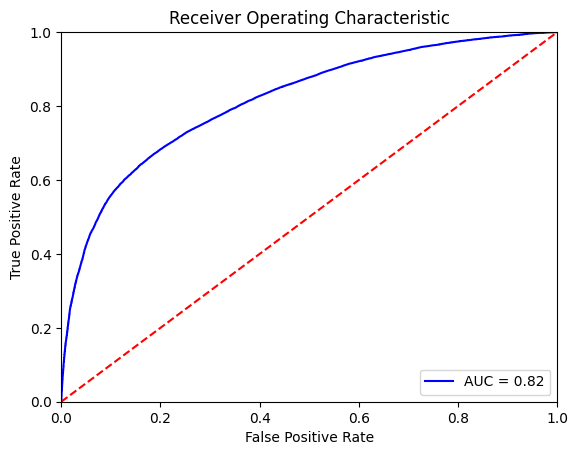

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(test_X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_Y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [50]:
from sklearn import linear_model
from sklearn.feature_selection import RFE

rfe = RFE(estimator = linear_model.LogisticRegression())
rfe.fit(train_X, train_Y)
train_X.columns[rfe.get_support()]

c:\Users\henry\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\henry\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Index(['RevolvingUtilizationOfUnsecuredLines',
       'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse'],
      dtype='object')

In [33]:
# X = train_no_outlier.drop(columns = "SeriousDlqin2yrs")
# y = train_no_outlier["SeriousDlqin2yrs"]
# over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1,k_neighbors=5)
# under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
# steps = [('over', over), ('under', under)]
# pipeline = imblearn.pipeline.Pipeline(steps=steps)

# X, y = pipeline.fit_resample(X, y)

In [34]:
# counts_balanced = collections.Counter(y)
# print(counts_balanced)

Counter({0: 27030, 1: 13515})
